# Machine Survival Analysis using WTTE-RNNs

## Introduction

Survival analysis is a set of methods to analyze the ‘time to occurrence’ of an event. The response is often referred to as a failure time, survival time, or event time. These methods are widely used in predictive maintenance to analyze the 'time to death' of a machine. 

In this project I aim to implement Weibull Time-to-event Recurrent Neural Networks (WTTE-RNNs) for predictive maintenance of a machine. The basic idea of the WTTE-RNN network is this: We want to design a model that can look at a timeline of historical features (observations from machines) leading upto the present and predict a distribution describing the likelihood that a particular event will happen as time moves into the future. The good model will predict a distribution that is weighted closer to the present for samples that are very close to experiencing an event and predict much wider distribution for samples that are unlikely to experience an event any time soon.

In order to accomplish this, I will use a neural network that can look at historical data and output the two parameters (alpha and beta) that control the shape of the Weibull distribution as Weibull distribution is commonly used to describe time-to-event data.

**Reference** : https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf

**Data**

I have 100MB of historical data from twenty of the units of a company that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year.

The company has a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). My objective is to see if there is a similarity in information of the units who had longest lives or shortest lives. Also, the company has thirty active units working in the field from the past month. My objective would be to predict which units will fail soon from the available information of previously failed units.

## Importing required Libraries

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data

import glob #to find filenames from directory matching a pattern
from tqdm import tqdm #for progress bar

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

#for weibull distribution
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

Using TensorFlow backend.


## Importing data

In [2]:
train_files = glob.glob('C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\train\\unit*_rms.csv')
test_files = glob.glob('C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\test\\unit*_rms.csv')

In [3]:
train_files[0:3]

['C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\train\\unit0000_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\train\\unit0001_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\train\\unit0002_rms.csv']

In [4]:
test_files[0:3]

['C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\test\\unit0020_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\test\\unit0021_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Internship\\Tagup\\data-science\\test\\unit0022_rms.csv']

Each unit's information is stored in separate file. I am making train and test dataframe which will contain the information of all failed units and currently active units respectively. I am adding three new variables : unit, cycle and remaining_cycles. "unit" will have the unit number, "cycle" will have number of data recording cycle since the begining and "remaining_cycles" will be remaining life of a unit untill failure in terms of data recording cycles.

In [5]:
df_train = pd.DataFrame()

for i in range(len(train_files)):
    df0 = pd.read_csv(train_files[i])
    df0["unit"] = i
    df0.timestamp = pd.to_datetime(df0.timestamp)
    
    df0["cycle"] = df0.index + 1
    maxCycle = len(df0)
    df0["remaining_cycles"] = [maxCycle - i for i in df0.index]
    
    df_train = pd.concat([df_train,df0])

In [6]:
df_train.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit,cycle,remaining_cycles
0,2003-12-13 19:56:43.777979848,0.150438,-0.059544,0.045503,5.084823,0.019528,0,1,91715
1,2003-12-13 20:07:32.457298714,0.511660,0.627101,0.208669,7.334172,2.081454,0,2,91714
2,2003-12-13 20:13:43.182783330,0.824233,1.732618,0.286401,8.843053,3.485346,0,3,91713
3,2003-12-13 20:27:19.295198297,1.506626,3.115258,0.483992,11.749493,6.041188,0,4,91712
4,2003-12-13 20:35:08.719032171,2.034869,3.923323,0.851620,12.947061,7.309662,0,5,91711


In [7]:
print("df_train has information of total", len(df_train.unit.value_counts().index) , "units.")
print("df_train has", df_train.shape[0], "observations and", df_train.shape[1], "features.")

df_train has information of total 20 units.
df_train has 990133 observations and 9 features.


In [8]:
df_test = pd.DataFrame()

for i in range(len(test_files)):
    df0 = pd.read_csv(test_files[i])
    df0["unit"] = i + 20 
    df0.timestamp = pd.to_datetime(df0.timestamp)
    df0["cycle"] = df0.index + 1
    
    df0["remaining_cycles"] = np.nan

    df_test = pd.concat([df_test,df0])

In [9]:
df_test.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit,cycle,remaining_cycles
0,2018-05-01 00:00:53.033586757,0.235075,0.088466,0.048467,5.029249,0.011926,20,1,NaN
1,2018-05-01 00:10:11.751901322,2.590762,5.120211,1.063173,8.542015,2.371336,20,2,NaN
2,2018-05-01 00:20:21.452190953,7.679248,14.877355,2.803815,13.513336,5.166404,20,3,NaN
3,2018-05-01 00:27:39.404285662,10.647193,21.288970,4.320174,17.407750,7.060859,20,4,NaN
4,2018-05-01 00:38:54.910044761,14.540066,29.243910,5.906701,22.570923,9.982019,20,5,NaN


In [10]:
print("df_test has information of total", len(df_test.unit.value_counts().index) , "units.")
print("df_test has", df_test.shape[0], "observations and", df_test.shape[1], "features.")

df_test has information of total 30 units.
df_test has 130699 observations and 9 features.


## Data Cleaning

The remote monitoring system of the company is antiquated and prone to communication errors, which manifest as nonsense measurements. This means there will be many invalid values in a dataset. There might be instances when the values did not get recorded and I will have to do extensive data cleaning to get rid of these errors.

Let's start by inspecting the mean values of each feature unit wise

In [11]:
df_train[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").mean()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
unit,,,,,
0,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
1,4.351757e+36,-2.035135e+38,-7.413540e+67,-1.447226e+53,-1.927103e+40
2,-2.689733e+37,2.685303e+35,-1.468081e+30,1.816023e+34,-9.146221e+39
3,2.454681e+110,2.789356e+50,2.447565e+91,-3.153717e+53,-1.177715e+62
4,7.741562e+63,-1.121681e+48,1.492939e+60,8.270559e+56,-1.307910e+76
5,1.695727e+77,3.316074e+81,2.930196e+49,-1.026680e+81,-1.448251e+48
6,4.263050e+67,-4.122228e+64,2.028051e+64,-3.388059e+93,-1.896344e+51
7,1.058303e+51,6.751820e+68,-1.496081e+51,7.068933e+56,-2.138988e+50
8,-9.826381e+38,-4.982600e+48,-2.144675e+41,3.030226e+37,-1.585852e+28


In [12]:
df_test[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").mean()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
unit,,,,,
20,4.024085e+46,-2.199737e+31,1.835507e+62,8.864209e+30,1.977555e+39
21,-7.145605e+56,-2.671431e+35,1.386158e+68,6.547940e+37,-3.398987e+28
22,1.854290e+31,6.846418e+27,-2.951948e+50,5.439132e+29,-2.275384e+26
23,2.310475e+24,5.787122e+21,1.405893e+17,3.081633e+38,8.353971e+27
24,-2.770103e+28,-6.318672e+28,3.378455e+30,-1.687553e+26,3.410752e+36
25,2.279505e+35,-1.284018e+35,-2.363226e+44,-1.071145e+39,7.790445e+39
26,-8.912164e+59,1.262633e+27,1.589000e+44,-4.795423e+41,-1.340337e+24
27,5.531341e+21,-2.209601e+31,-3.590208e+28,-4.178592e+32,2.353553e+24
28,-1.094062e+23,7.719042e+48,-8.162883e+63,2.701588e+39,-1.529098e+24


Mean variable values of all units can be seen above. The mean values go from negative to as high as e+100. This tells us that the data is extremely noisy. Also, higher anomalies can be meant as somethings is wrong with the unit and it will require maintenance soon.

Let's start by removing negative values

In [13]:
feats = ["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]

In [14]:
df_train[df_train[feats] < 0 ] = np.nan
df_test[df_test[feats] < 0 ] = np.nan

Let's deal with the observations which have higher than normal values. To detect and remove outliers I am using upperbound as 0.99 quantile values of features.

Let's see the 0.99 quantile values of variables unit wise

In [15]:
df_train[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").quantile(0.99)

0.99,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
unit,,,,,
0,1220.143592,333.721535,50.766256,288.964620,202.697844
1,1209.970199,332.370964,50.895190,229.960033,110.235678
2,1177.966818,261.158516,36.072952,224.083056,167.395662
3,1213.260502,331.743069,50.575133,233.507603,161.933479
4,1400.771001,334.429051,50.781358,236.073131,180.899417
5,1220.759139,329.035937,50.226535,240.069645,171.086514
6,1217.495940,332.515302,50.786054,233.563161,158.967629
7,1213.892400,333.783025,50.733095,230.476194,126.454180
8,1213.618102,276.342961,38.204612,148.427662,86.971901


In [16]:
df_test[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").quantile(0.99)

0.99,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
unit,,,,,
20,1199.755855,321.471820,48.891293,220.035749,104.646018
21,1200.793808,323.804334,49.469003,318.743472,226.113872
22,1274.206423,324.081090,49.059459,270.410988,176.625973
23,1187.092262,284.548188,41.626364,169.330393,88.272268
24,1196.794736,327.927334,50.246486,227.333213,107.343005
25,1212.707108,325.077177,49.753613,225.829924,128.106052
26,1575.239438,337.818956,49.797671,225.291688,152.170319
27,1582.025695,348.409819,50.220812,352.246700,241.461922
28,1538.580726,346.723289,50.389033,328.458901,227.586462


By inspecting above values, we can say that these values look legitimate.

Let's see the overall 0.99 quantile values in train and test datasets.

In [17]:
df_train[["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].quantile(0.99)

rpm              1216.766500
motor_voltage     332.063686
motor_current      50.641771
motor_temp        233.116470
inlet_temp        158.663989
Name: 0.99, dtype: float64

In [18]:
df_test[["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].quantile(0.99)

rpm              1217.329007
motor_voltage     327.186630
motor_current      49.952896
motor_temp        260.495304
inlet_temp        184.627932
Name: 0.99, dtype: float64

As we can see 0.99 quantile values in both train and test dataset are very close. For simplicity I am considering an observation as an outlier if it's value goes above 1.5 times the 0.99 quantile value and I am replacing that observation with Null values.

In [19]:
df_train[df_train[feats] > df_train[feats].quantile(0.99)*1.5] = np.nan
df_test[df_test[feats] > df_test[feats].quantile(0.99)*1.5] = np.nan

Let's see the null values in both dataframes.

In [20]:
df_train.isnull().sum()

timestamp               0
rpm                 16709
motor_voltage       16988
motor_current       17503
motor_temp          12171
inlet_temp          12238
unit                    0
cycle                   0
remaining_cycles        0
dtype: int64

In [21]:
df_test.isnull().sum()

timestamp                0
rpm                   2355
motor_voltage         2379
motor_current         2401
motor_temp            1491
inlet_temp            1542
unit                     0
cycle                    0
remaining_cycles    130699
dtype: int64

## Data Imputation

Both of the datasets have lots of null values and I will have to deal with them. To impute the null values in data, first let's check if there is a trend in our data.

#### Unit 0 Feature Values Plots

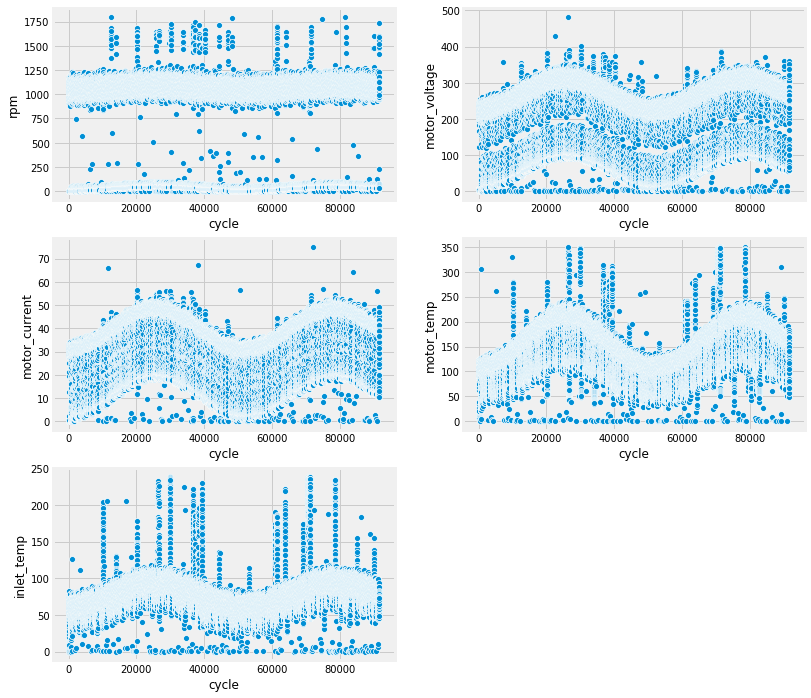

In [22]:
temp_df = df_train[df_train.unit == 0]
plt.figure(figsize = (12,12))

plt.subplot(321)
sns.scatterplot(x = temp_df.cycle, y = temp_df.rpm)

plt.subplot(322)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_voltage)

plt.subplot(323)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_current)

plt.subplot(324)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_temp)

plt.subplot(325)
sns.scatterplot(x = temp_df.cycle, y = temp_df.inlet_temp)

#### Unit 1 Feature Values Plots

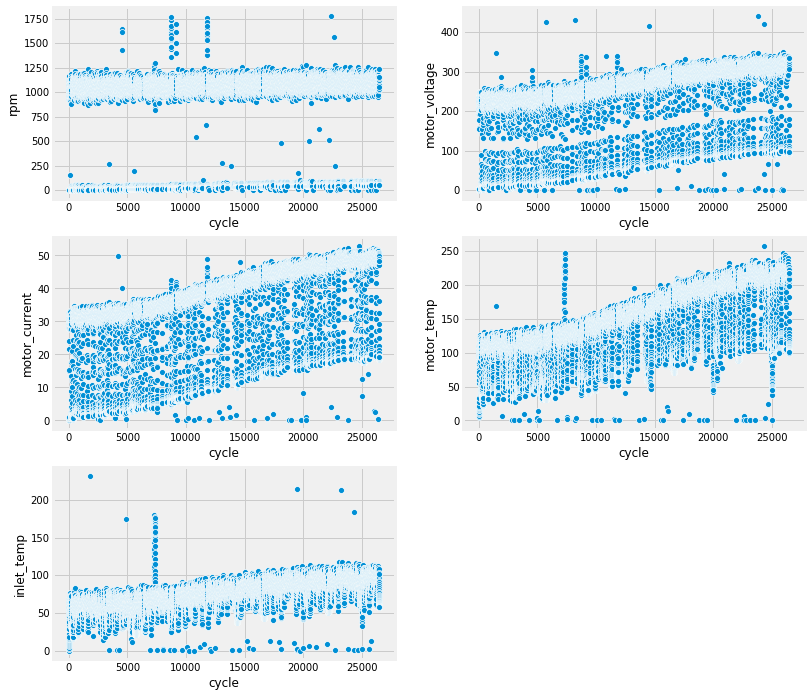

In [23]:
temp_df = df_train[df_train.unit == 1]
plt.figure(figsize = (12,12))

plt.subplot(321)
sns.scatterplot(x = temp_df.cycle, y = temp_df.rpm)

plt.subplot(322)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_voltage)

plt.subplot(323)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_current)

plt.subplot(324)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_temp)

plt.subplot(325)
sns.scatterplot(x = temp_df.cycle, y = temp_df.inlet_temp)


From above graphs we can say that the value of rpm almost remains constant and all other features are highly correlated with eachother. We can fill the null values of data with rolling average as in this sequential data most of the time features have values similar to past cycle's values. Here, I am making an assumption that feature values do not increase or descrease abruptly. For filling null values with rolling mean I use center method with window size = 6 including the null value.

I will run iterations untill all the values in dataframe get filled by rolling mean. Also, there are chances of introducing bias as these might not be true values but we will have to take the risk. Null values are not many compared to overall dataset so, imputing rolling mean should not affect our results much.

In [24]:
while((df_train[feats].isnull().sum() > 0).values.sum()):
    df_train[feats] = df_train[feats].fillna(df_train[feats].rolling(min_periods=1, center=True, window=6).mean())

In [25]:
while((df_test[feats].isnull().sum() > 0).values.sum()):
    df_test[feats] = df_test[feats].fillna(df_test[feats].rolling(min_periods=1, center=True, window=6).mean())

In [26]:
df_train.isnull().sum()

timestamp           0
rpm                 0
motor_voltage       0
motor_current       0
motor_temp          0
inlet_temp          0
unit                0
cycle               0
remaining_cycles    0
dtype: int64

In [27]:
df_test.isnull().sum()

timestamp                0
rpm                      0
motor_voltage            0
motor_current            0
motor_temp               0
inlet_temp               0
unit                     0
cycle                    0
remaining_cycles    130699
dtype: int64

## Model Building

### Loss Function

I need a loss function that helps me to evaluate the model performance and backpropogates cost information through the network. The discrete log-likelihood function for hazard function on censored survival data can be implemented below.

In [28]:
def weibull_loglik_discrete(y_true, ab_pred):
    """
        Dicrete log-likelihood for weibull hazard function on censored survival data
        y_true: tensor containing time-to-event (y) and an event indicator (u)
        ab_pred: tensor containing predicted weibull alpha and beta
    """
    
    y = y_true[:, 0]
    u = y_true[:, 1]
    a = ab_pred[:, 0]
    b = ab_pred[:, 1]
    
    hazard0 = k.pow((y + 1e-35) / a, b)
    hazard1 = k.pow((y + 1) / a, b)
    
    return -1 * k.mean(u * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

Usually we want to maximize the log-likelihood, but keras minimizes loss, so we multiply by -1.

### Keras Activation Function

I need an exponential activation function for alpha and softplus for beta. Unfortunately, keras does not support applying different activation functions to the individual neurons and that is why I am defining a custom activation function.

In [29]:
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])
    
    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))
    
    return k.concatenate((a, b), axis = 1)

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [30]:
train = df_train.copy()
test = df_test.copy()

In [31]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

In [32]:
df_train.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit,cycle,remaining_cycles
0,2003-12-13 19:56:43.777979848,-0.999835,-0.995240,-0.998807,-0.970917,-0.999839,0,1,91715
1,2003-12-13 20:07:32.457298714,-0.999438,-0.997471,-0.994486,-0.958051,-0.982511,0,2,91714
2,2003-12-13 20:13:43.182783330,-0.999094,-0.993009,-0.992428,-0.949421,-0.970713,0,3,91713
3,2003-12-13 20:27:19.295198297,-0.998344,-0.987429,-0.987195,-0.932797,-0.949234,0,4,91712
4,2003-12-13 20:35:08.719032171,-0.997763,-0.984167,-0.977460,-0.925947,-0.938574,0,5,91711


In [33]:
df_test.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit,cycle,remaining_cycles
0,2018-05-01 00:00:53.033586757,-0.999747,-0.999643,-0.998778,-0.974061,-0.999928,20,1,NaN
1,2018-05-01 00:10:11.751901322,-0.997159,-0.979015,-0.971685,-0.955941,-0.982809,20,2,NaN
2,2018-05-01 00:20:21.452190953,-0.991571,-0.939016,-0.925208,-0.930298,-0.962528,20,3,NaN
3,2018-05-01 00:27:39.404285662,-0.988311,-0.912731,-0.884721,-0.910209,-0.948782,20,4,NaN
4,2018-05-01 00:38:54.910044761,-0.984036,-0.880120,-0.842359,-0.883576,-0.927586,20,5,NaN


LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [35]:
def gen_train(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
        mask_values = mask value to avoid different length of sequence data
    """
    
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [36]:
def gen_target(df):
    """
        function to prepare target data into (remaining_cycle, event)
        df = dataframe whose target dataframe is to generate
        event = event indicator which will be always 1 for our data
    """
    
    df_label = pd.DataFrame()
    
    units_id = df.unit.unique()
    for i in units_id:
        temp_df = df.remaining_cycles[df.unit == i]
        df_label = pd.concat([df_label, temp_df])
    
    df_label["event"] = 1
    return df_label.values

In [37]:
def gen_test(id_df, seq_length, seq_cols):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

The data is very big and to make calculations computationally efficient, I am truncating the train dataset.

In [39]:
train = df_train[df_train.remaining_cycles <= 10000]

Let's define look back period and mask_value

In [40]:
sequence_length = 100
mask_value = -99

Let's prepare data using above functions.

In [42]:
#generate train
x_train=np.concatenate(list(list(gen_train(train[train['unit']==unit], sequence_length, feats, mask_value)) for unit in train['unit'].unique()))
print(x_train.shape)

(179313, 100, 5)


In [44]:
#generate target of train
y_train= gen_target(train)
print(y_train.shape)

(179313, 2)


In [45]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['unit']==unit], sequence_length, feats)) for unit in df_test['unit'].unique()))
print(x_test.shape)

(30, 100, 5)


### Model

In [63]:
tte_mean_train = np.nanmean(y_train [:,0])
mean_u = np.nanmean (y_train [:,1] )

# Initialization value for alpha-bias 
init_alpha = -1.0 / np.log (1.0- 1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u

print('tte_mean_train', tte_mean_train) 
print('init_alpha: ',init_alpha)
print('mean uncensored train: ',mean_u)

tte_mean_train 4771.5538416065765
init_alpha:  4772.053824143451
mean uncensored train:  1.0


In [66]:
k.set_epsilon(1e-10)

history = History()
weightwatcher = WeightWatcher()
nanterminator = callbacks.TerminateOnNaN()

n_features = x_train.shape[-1]

# Start building our model
model = Sequential()

model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))

model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))

model.add(Dense(2))

# Apply the custom activation function mentioned above

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5))

model.summary()

C:\Users\archd\Anaconda3\lib\site-packages\wtte\wtte.py:89: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  warnings.warn(message)
C:\Users\archd\Anaconda3\lib\site-packages\wtte\wtte.py:89: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  warnings.warn(message)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, None, 5)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 20)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
lambda_3 (Lambda)            (None, 2)                 0         
Total params: 1,602
Trainable params: 1,602
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(x_train, y_train,
              epochs=50,
              batch_size=1000, 
              verbose=2,
              validation_split = 0.1,
              callbacks=[nanterminator,history,weightwatcher])

Train on 161381 samples, validate on 17932 samples
Epoch 1/50
 - 53s - loss: 9.3643 - val_loss: 9.2923
Epoch 2/50
 - 52s - loss: 9.3550 - val_loss: 9.2657
Epoch 3/50
 - 52s - loss: 9.3499 - val_loss: 9.2561
Epoch 4/50
 - 50s - loss: 9.3431 - val_loss: 9.2354
Epoch 5/50
 - 49s - loss: 9.3342 - val_loss: 9.2566
Epoch 6/50
 - 51s - loss: 9.3227 - val_loss: 9.3117
Epoch 7/50
 - 48s - loss: 9.3162 - val_loss: 9.2715
Epoch 8/50
 - 49s - loss: 9.3108 - val_loss: 9.2750
Epoch 9/50
 - 52s - loss: 9.3486 - val_loss: 9.3127
Epoch 10/50
 - 50s - loss: 9.3616 - val_loss: 9.3038
Epoch 11/50
 - 49s - loss: 9.3610 - val_loss: 9.3406
Epoch 12/50
 - 50s - loss: 9.3603 - val_loss: 9.3025
Epoch 13/50
 - 51s - loss: 9.3609 - val_loss: 9.2894
Epoch 14/50
 - 52s - loss: 9.3605 - val_loss: 9.2875
Epoch 15/50
 - 51s - loss: 9.3602 - val_loss: 9.2975
Epoch 16/50
 - 51s - loss: 9.3593 - val_loss: 9.2836
Epoch 17/50
 - 51s - loss: 9.3606 - val_loss: 9.2938
Epoch 18/50
 - 51s - loss: 9.3603 - val_loss: 9.2810
Epoc

Let's plot the loss, biases and weights

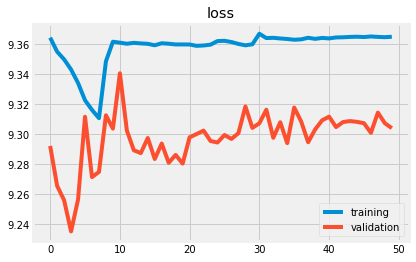

In [68]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

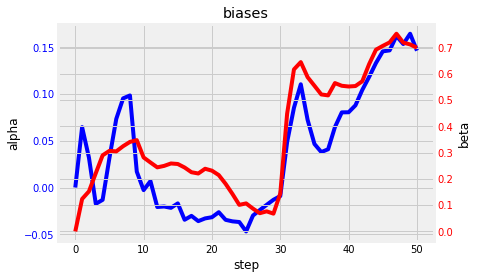

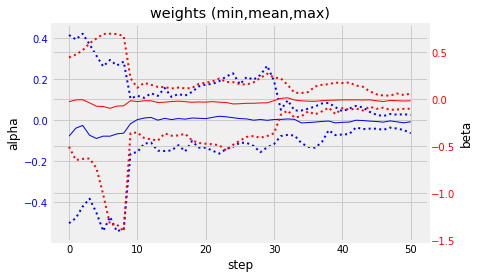

In [69]:
weightwatcher.plot()

Let's predict alpha and beta parameters for test data

In [70]:
test_predict = model.predict(x_test)
test_predict = np.resize(test_predict, (30, 2))
test_results_df = pd.DataFrame(test_predict, columns=['alpha', 'beta'])
test_results_df["unit"] = df_test["unit"].unique()

In [71]:
test_results_df

,alpha,beta,unit
0,5419.370117,1.603165,20
1,5276.268555,1.597190,21
2,5146.710938,1.528814,22
3,5291.332520,1.505220,23
4,5380.982910,1.596224,24
5,5160.771973,1.448131,25
6,5406.837402,1.600105,26
7,5448.558105,1.662451,27
8,5449.834961,1.597875,28
9,5309.819824,1.571885,29
